In [1]:
import numpy as np

"""
Basic neuron model with shared instantiation
"""
class Neuron:
  def __init__(self, weights=0):
    np.seterr(all='ignore')
    self.input = 0
    self.value = 0
    self.output = 0
    self.threshold = 0
    self.fired = False
    self.potential = 0
    self.weights = np.array([self.init_weight(weights) for x in range(weights)], dtype='float64')

  def fire(self):
    self.fired = True if (self.value > self.threshold) else False
    if self.fired:
      self.value = 0
    return 1 if self.fired else 0

  def init_weight(self, num_weights):
    return np.random.uniform(-(2 / num_weights), (2 / num_weights))

  def solve(self):
    raise NotImplementedError("A neuron model needs a solve method")


In [2]:

"""
Leaky Integrate and Fire neuron model
"""
class LeakyIntegrateAndFireNeuron(Neuron):
  def __init__(self, weights=0):
    super(self.__class__, self).__init__(weights)
    self.degradation = 0.9
    self.refractoryTime = 0

  def calculate_potential (self, inputs):
    self.potential = (self.potential + np.sum(np.multiply(inputs, self.weights))) * self.degradation
    return self.potential

  def solve(self, inputs):
    self.inputs = inputs
    if self.refractoryTime > 0:
      self.refractoryTime = self.refractoryTime - 1
    else:
      self.value = self.calculate_potential(inputs)
    self.fire()
    if self.fired: self.refractoryTime = 2
    return self.fired

In [3]:
class LearningMethod:
  def update(self):
    raise NotImplementedError("A learning method needs an update method")

In [4]:
"""
Basic STDP Learning Method
"""
class STDP(LearningMethod):
  def __init__(self):
    self.adjustment = 0.1
    self.time = 0
    self.is_setup = False

  def update_weights(self, neuron, adjustment):
    adjustments = np.multiply(neuron.inputs, adjustment)
    signed_adjustments = np.multiply(adjustments, np.sign(neuron.weights))
    adjusted = np.add(neuron.weights, signed_adjustments)
    return adjusted

  def update_trace(self, neuron):
    trace = [ 0 if x == 0 else neuron.trace[int(i)] + 1 for (i, x) in enumerate(1 - neuron.inputs)]
    return trace

  def setup(self, neuron):
    neuron.trace = np.zeros(len(neuron.inputs))

  def update(self, layers):
    for layer in layers:
      for neuron in layer:
        if (not self.is_setup):
          self.setup(neuron)
        correlated_adjustment = self.adjustment if neuron.refractoryTime is 0 else -self.adjustment
        neuron.weights = self.update_weights(neuron, correlated_adjustment)
        neuron.trace = self.update_trace(neuron)
    if (not self.is_setup): self.is_setup = True
    self.time = self.time + 1

In [5]:
import numpy as np

"""
Spiking Neural Network model
"""
class SNN:
  def __init__(self, num_input, hidden_layers, num_output, neuron_class, learning_method):
    self.layers = []
    self.neuronClass = neuron_class
    self.learning = learning_method
    self.setup(num_input, hidden_layers, num_output)

  def setup(self, num_input, hidden_layers, num_output):
    self.setup_layer(num_input)
    self.setup_hidden(hidden_layers)
    self.setup_layer(num_output)

  def setup_layer(self, num_neurons):
    layer_neurons = np.array([])
    for x in range(num_neurons):
      input_weights = len(self.layers[-1]) if len(self.layers) > 0 else num_neurons
      layer_neurons = np.append(layer_neurons, self.neuronClass(input_weights))
    self.layers.append(layer_neurons)

  def setup_hidden(self, hidden_layers):
    if type(hidden_layers) is int:
      self.setup_layer(hidden_layers)
    else:
      for layer in hidden_layers:
        self.setup_layer(layer)

  def adjust_weights(self):
    self.learning.update(self.layers)

  def solve(self, input):
    previous_layer = np.array(input)
    for (i, layer) in enumerate(self.layers):
      new_previous_layer = np.array([])
      for neuron in layer:
        new_previous_layer = np.append(new_previous_layer, neuron.solve(previous_layer))
      previous_layer = new_previous_layer
    self.adjust_weights()
    return previous_layer


0
[-0.83719321  0.37317334]


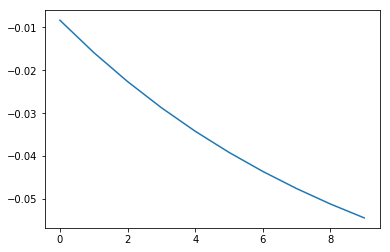

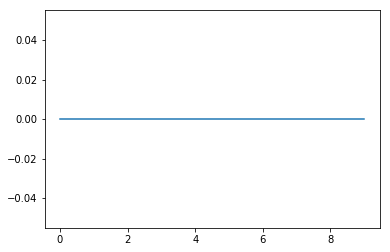

In [8]:
N = 2

l=LeakyIntegrateAndFireNeuron(N)

print(l.potential)
print(l.weights)

a=[]
s=[]
for i in range(10):
    s.append(l.solve([0.02]*N))
    a.append(l.potential)
import matplotlib.pyplot as plt

plt.plot(a)
plt.show()

plt.plot(s)
plt.show()

In [9]:

net = SNN(3, [2, 4], 6, LeakyIntegrateAndFireNeuron, STDP())
print(net.layers[0][0].weights)
print('Final', net.solve([ 1, 1, 1]))
print(net.layers[0][0].weights)
print('Final', net.solve([ 1, 1, 1]))
print(net.layers[0][0].weights)
print('Final', net.solve([ 1, 1, 1]))
print(net.layers[0][0].weights)

[-0.52650114  0.24652997 -0.18722644]
Final [0. 0. 0. 0. 0. 0.]
[-0.62650114  0.34652997 -0.28722644]
Final [0. 0. 0. 0. 0. 0.]
[-0.72650114  0.44652997 -0.38722644]
Final [0. 0. 0. 0. 0. 0.]
[-0.82650114  0.54652997 -0.48722644]
